- Train a 2 layer CNN + 2 layer MLP on the MNIST dataset using PyTorch
- Train a Sparse Autoencoder at the output of the CNN
- Get the correlation matrix of act/attr of these sparse features
- Fit a SBM to this weighted functional graph
- Identify ROIs and classes
- for all class c and labeled ROI of class c, ablate these features and measure the drop in accuracy across classes
- Do the same with a spectral clustering and a louvain clustering

In [1]:
# import MNIST data and torch
import os

import numpy as np

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm

from welford_torch import OnlineCovariance

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Hyper-parameters
input_size = 28
hidden_size = 128
num_layers = 2

num_classes = 10

epochs = 10
lr = 1e-3
batch_size = 100

In [3]:
# MNIST dataset
root = './data/MNIST/'
train_dataset = torchvision.datasets.MNIST(
    root=root,
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root=root,
    train=False,   
    transform=transforms.ToTensor()
)

# Data loader
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [4]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2), # 28x28x1 -> 28x28x32
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2), # 14x14x32 -> 14x14x64
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(7*7*64, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [5]:
class SAE(nn.Module):
    def __init__(self, input_size, hidden_size):
        """One layer MLP Autoencoder trained with sparsity constraint"""
        super(SAE, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size, bias=True)
        self.decoder = nn.Linear(hidden_size, input_size, bias=False)
        self.decoder.weight = nn.Parameter(self.encoder.weight.t())
        self.encoder.bias = nn.Parameter(torch.zeros(hidden_size))
        self.bias = nn.Parameter(torch.randn(input_size))
        self.hidden_size = hidden_size
        self.input_size = input_size

    def encode(self, x):
        return torch.relu(self.encoder(x))
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x, output_features=False):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        if output_features:
            return encoded, decoded
        return decoded

In [6]:
def train_CNN(model, train_loader, test_loader, loss_fn, optimizer, device, epochs=10):
    lossess = []
    step = 0
    for epoch in range(epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            logits = model(images)
            loss = loss_fn(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                lossess.append(loss.item())
                print(f"Epoch [{epoch+1}/{epochs}], Step [{step+1}/{len(train_loader) * epochs}], Loss: {loss.item()}")
            step += 1
        
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                logits = model(images)
                _, predicted = torch.max(logits.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            print(f"Epoch [{epoch+1}/{epochs}], Accuracy: {correct / total}")
    return lossess

def train_SAE(model, sae, train_loader, test_loader, loss_fn, alpha, optimizer, device, epochs=10):
    model.eval()
    act_buffer = []
    hook = model.layer2.register_forward_hook(lambda module, input, output: act_buffer.append(output))
    lossess = []
    step = 0

    for epoch in range(epochs):
        sae.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            _ = model(images)
            act = act_buffer.pop() # batch_size x 64 x 7 x 7
            act = act.permute(0, 2, 3, 1).reshape(-1, 64)
            f, reconstructed = sae(act, output_features=True)
            mse = loss_fn(reconstructed, act)
            a = 0.9
            L1 = ((f.abs()**a).sum(dim=-1)**(1/a)).mean()
            loss = mse + alpha * L1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                lossess.append(loss.item())
                print(f"Epoch [{epoch+1}/{epochs}], Step [{step+1}/{len(train_loader) * epochs}], Loss: {loss.item()}\n\tMSE: {mse.item()}, Variance explained: {1 - mse.item() / act.var().item()}\n\tL1: {L1.item()}, L0: {(f > 1e-6).sum(dim=-1).float().mean().item()}")

            step += 1

    # remove hook
    hook.remove()

In [11]:
# train CNN
if not os.path.exists('./mnist_cnn.pth'):
    cnn_model = MNIST_CNN().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=lr)
    losses = train_CNN(cnn_model, train_loader, test_loader, loss_fn, optimizer, device, epochs=10)

    # save CNN model
    torch.save(cnn_model.state_dict(), './mnist_cnn.pth')
else:
    cnn_model = MNIST_CNN().to(device)
    cnn_model.load_state_dict(torch.load('./mnist_cnn.pth'))

Epoch [1/10], Step [100/6000], Loss: 0.1395106315612793
Epoch [1/10], Step [200/6000], Loss: 0.11758039146661758
Epoch [1/10], Step [300/6000], Loss: 0.08746381103992462
Epoch [1/10], Step [400/6000], Loss: 0.07120366394519806
Epoch [1/10], Step [500/6000], Loss: 0.09755419939756393
Epoch [1/10], Step [600/6000], Loss: 0.021993767470121384
Epoch [1/10], Accuracy: 0.9854
Epoch [2/10], Step [700/6000], Loss: 0.029922517016530037
Epoch [2/10], Step [800/6000], Loss: 0.0653398409485817
Epoch [2/10], Step [900/6000], Loss: 0.0563686266541481
Epoch [2/10], Step [1000/6000], Loss: 0.02699245512485504
Epoch [2/10], Step [1100/6000], Loss: 0.04158259555697441
Epoch [2/10], Step [1200/6000], Loss: 0.014885008335113525
Epoch [2/10], Accuracy: 0.991
Epoch [3/10], Step [1300/6000], Loss: 0.03944613039493561
Epoch [3/10], Step [1400/6000], Loss: 0.025416860356926918
Epoch [3/10], Step [1500/6000], Loss: 0.004010405391454697
Epoch [3/10], Step [1600/6000], Loss: 0.013753663748502731
Epoch [3/10], Ste

In [13]:
# train SAE
exp_factor = 10
if not os.path.exists('./mnist_sae.pth'):
    sae = SAE(64, int(exp_factor * 64)).to(device)
    alpha = 1e-2
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(sae.parameters(), lr=lr)
    losses = train_SAE(cnn_model, sae, train_loader, test_loader, loss_fn, alpha, optimizer, device, epochs=epochs)

    # save SAE model
    torch.save(sae.state_dict(), './mnist_sae.pth')
else:
    sae = SAE(64, int(exp_factor * 64)).to(device)
    sae.load_state_dict(torch.load('./mnist_sae.pth'))

Epoch [1/10], Step [100/6000], Loss: 0.544214129447937
	MSE: 0.15476393699645996, Variance explained: 0.7637860848280538
	L1: 38.94501876831055, L0: 67.96142578125
Epoch [1/10], Step [200/6000], Loss: 0.43013399839401245
	MSE: 0.13239000737667084, Variance explained: 0.8133810349082166
	L1: 29.77440071105957, L0: 42.44081497192383
Epoch [1/10], Step [300/6000], Loss: 0.3723796308040619
	MSE: 0.11511290073394775, Variance explained: 0.8425920009285021
	L1: 25.726673126220703, L0: 29.80714225769043
Epoch [1/10], Step [400/6000], Loss: 0.3273269236087799
	MSE: 0.10137323290109634, Variance explained: 0.8573494716071236
	L1: 22.595369338989258, L0: 22.447959899902344
Epoch [1/10], Step [500/6000], Loss: 0.29686984419822693
	MSE: 0.09236947447061539, Variance explained: 0.8675567570510289
	L1: 20.45003890991211, L0: 18.427143096923828
Epoch [1/10], Step [600/6000], Loss: 0.27966803312301636
	MSE: 0.08434242010116577, Variance explained: 0.8801312851338943
	L1: 19.532560348510742, L0: 16.149

In [83]:
# get the feature correlation matrix
cov = OnlineCovariance()
cnn_model.eval()
sae.eval()

with torch.no_grad():
    act_buffer = []
    hook = cnn_model.layer2.register_forward_hook(lambda module, input, output: act_buffer.append(output))
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        _ = cnn_model(images)
        act = act_buffer.pop() # batch_size x 64 x 7 x 7
        act = act.permute(0, 2, 3, 1).reshape(-1, 64)
        f = act#sae.encode(act)
        cov.add_all(f)
    hook.remove()

100%|██████████| 600/600 [00:16<00:00, 36.94it/s]


# SBM

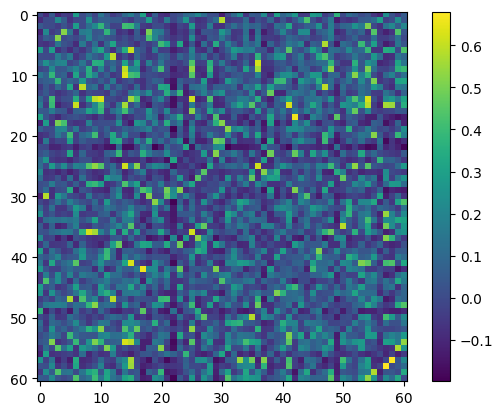

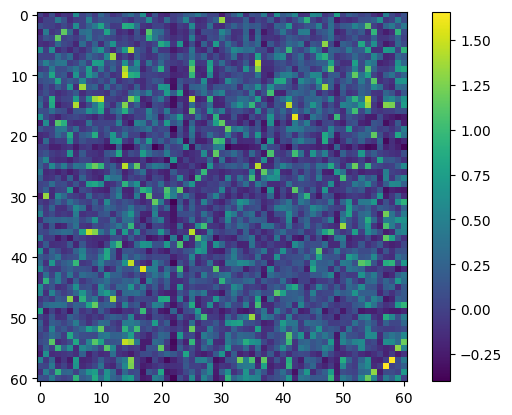

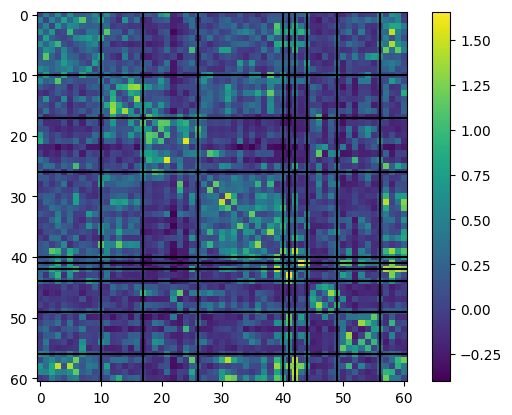

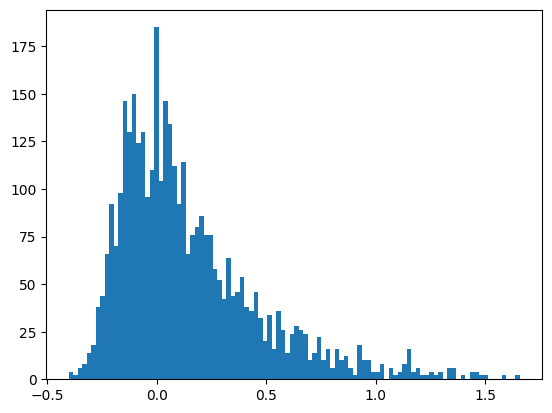

In [84]:
# visualize the feature correlation matrix
corr = cov.cov
eps = 1e-5
diag = corr.diag().clone()
dead_idx = diag < eps
corr = corr[~dead_idx][:, ~dead_idx]
diag = diag[~dead_idx]
corr = corr / torch.sqrt(diag.unsqueeze(0) * diag.unsqueeze(1))
diag_idx = torch.arange(corr.size(0))
corr[diag_idx, diag_idx] = 0
weights = 2 * torch.arctanh(corr)

import matplotlib.pyplot as plt
plt.imshow(corr.cpu().numpy())
plt.colorbar()
plt.show()

plt.imshow(weights.cpu().numpy())
plt.colorbar()
plt.show()

# spectral clustering : reordering the weights matrix based on the eigenvectors of the weights matrix
U, S, V = torch.svd(weights)
k = 10
Uk = U[:, :k]
X = Uk / torch.sqrt(S[:k])
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=k, n_init=10)
kmeans.fit(X.cpu().numpy())
labels = kmeans.labels_
idx = np.argsort(labels)
plt.imshow(weights[idx][:, idx].cpu().numpy())

labels_ = labels[idx]
diff = np.diff(labels_)
idx = np.where(diff)[0]
# add vertical and horizontal lines at the cluster boundaries
for i in idx:
    plt.axvline(i, color='black')
    plt.axhline(i, color='black')
plt.colorbar()
plt.show()

# weights distribution
plt.hist(weights.cpu().numpy().flatten(), bins=100)
plt.show()

# label the original features idx, add a label for dead features :
feature_labels = torch.zeros(cov.cov.size(0)).long()
feature_labels[dead_idx] = -1
feature_labels[~dead_idx] = torch.tensor(labels).long()

In [32]:
import graph_tool.all as gt

g = gt.Graph(directed=False)
edge_list = torch.nonzero(torch.ones_like(cov)).numpy()
weight_assignment = weights.numpy()[edge_list[:, 0], edge_list[:, 1]]

g.add_edge_list(edge_list)
g.ep['weight'] = g.new_edge_property("float", vals=weight_assignment)

state_args = {}
state_args[deg_corr] = False
state_args['recs']=[g.ep['weight']]
state_args['rec_types']=['real-normal']

state = gt.minimize_nested_blockmodel_dl(g, state_args=state_args)

for i in tqdm(range(100)):
    state.multiflip_mcmc_sweep(beta=np.inf, niter=10)

state.print_summary()

ModuleNotFoundError: No module named 'graph_tool'

In [ ]:
def plot_block_corr(cov, state, save_path=None):
    """
    Plot the correlation matrix reordered by the block assignments. Plot lines between the blocks.
    """
    corr = cov.numpy()
    blocks = state.get_levels()[0].get_blocks().a
    perm = np.argsort(blocks)
    corr = corr[perm][:, perm]
    blocks = blocks[perm]

    # Pad with zeros to separate the blocks
    block_diff = np.diff(blocks)
    block_diff = np.concatenate([[1], block_diff])
    idx_to_insert = np.where(block_diff)[0]

    corr = np.insert(corr, idx_to_insert, 0, axis=0)
    corr = np.insert(corr, idx_to_insert, 0, axis=1)

    # Plot the correlation matrix
    fig, ax = plt.subplots()
    ax.matshow(corr, cmap='twilight')

    # Now the lines appear white, and we want them to be black. Plot them manually
    for i, idx in enumerate(idx_to_insert):
        ax.axhline(idx + i, color='black', linewidth=0.5)
        ax.axvline(idx + i, color='black', linewidth=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    
    # Save the plot
    if save_path is not None:
        plt.savefig(save_path)
    else:
        raise ValueError("No save path provided.")

    # now plot the distribution of the correlation coefficients
    fig, ax = plt.subplots()
    ax.hist(corr.flatten(), bins=1000)
    ax.set_yscale('log')
    ax.set_title("Correlation coefficients distribution")
    # save the plot
    if save_path is not None:
        plt.savefig(save_path.replace(".png", "_hist.png"))
    else:
        raise ValueError("No save path provided.")

Get all act / attr of each module on every sample (n_blocks * 60k matrix), mean over classes (n_blocks * 10 matrix)

In [87]:
# get the feature correlation matrix
cnn_model.eval()
sae.eval()

all_labels = list(set(feature_labels.numpy()))
n_blocks = len(all_labels)
n_samples = train_dataset.data.size(0)
print(f"Number of blocks: {n_blocks}, Number of samples: {n_samples}")
act_over_sample = torch.zeros(n_blocks, 6000)
act_over_class = torch.zeros(n_blocks, num_classes)

with torch.no_grad():
    act_buffer = []
    hook = cnn_model.layer2.register_forward_hook(lambda module, input, output: act_buffer.append(output))

    dataset = train_dataset
    inputs = dataset.data.unsqueeze(1).float() / 255
    labels = dataset.targets

    rand_choice = torch.randperm(inputs.size(0))[:6000]

    inputs = inputs[rand_choice]
    labels = labels[rand_choice]

    class_perm = torch.argsort(labels)
    images = inputs.to(device)[class_perm]
    labels = labels[class_perm]
    _ = cnn_model(images)
    act = act_buffer.pop() # batch_size x 64 x 7 x 7
    act = act.permute(0, 2, 3, 1).reshape(-1, 64)
    f = act#sae.encode(act) # batch_size*7*7 x 64
    f = f.reshape(images.shape[0], 7, 7, 64).permute(0, 3, 1, 2) # batch_size x 640 x 7 x 7
    for i, class_idx in enumerate(range(num_classes)):
        for label in all_labels:
            class_idxes = (labels == class_idx)
            feature_idx = (feature_labels == label)
            act_over_sample[label, class_idxes] = f[class_idxes][:, feature_idx].mean(dim=(1, 2, 3))
            act_over_class[label, class_idx] = f[class_idxes][:, feature_idx].mean()
        
    hook.remove()

Number of blocks: 11, Number of samples: 60000


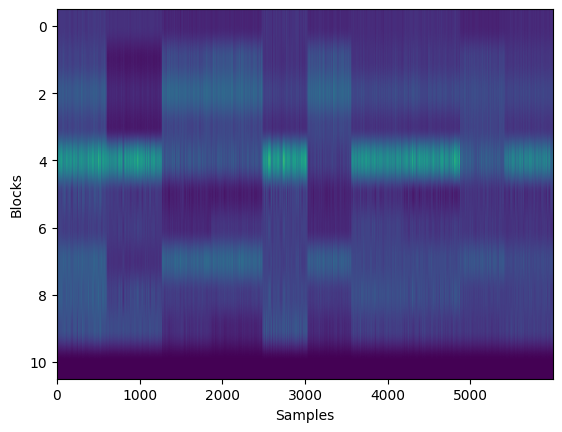

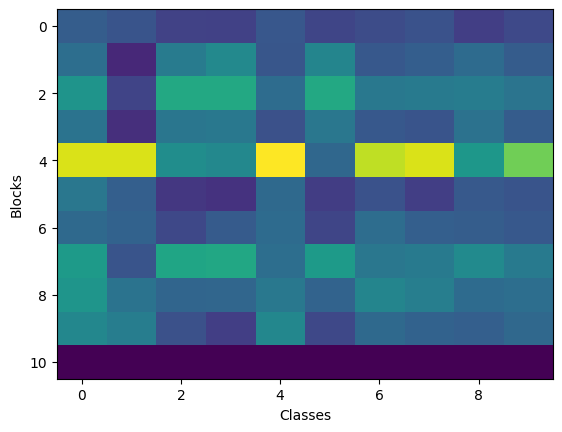

In [88]:
# plot the feature activation over samples
fig, ax = plt.subplots()
ax.imshow(act_over_sample.numpy(), aspect='auto')
ax.set_xlabel("Samples")
ax.set_ylabel("Blocks")
plt.show()

# plot the feature activation over classes
fig, ax = plt.subplots()
ax.imshow(act_over_class.numpy(), aspect='auto')
ax.set_xlabel("Classes")
ax.set_ylabel("Blocks")
plt.show()